In [20]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display
import PIL.Image

In [21]:
tf.random.set_seed(42)

In [22]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_image(image,3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    return image

In [24]:
def resize_image(image, input_shape):
    # processed_image = tf.keras.applications.vgg19.preprocess_input(image*255)
    processed_image = tf.image.resize(image, size = input_shape)
    # processed_image = tf.image.resize(processed_image, size = (224,224))
    processed_image = tf.expand_dims(processed_image,0)
    return processed_image

In [25]:
def content_loss(generated_output, content_outputs):
    loss = 0.5*tf.reduce_sum(tf.square(tf.subtract(content_outputs,generated_output)))
    return loss

In [26]:
def gram_matrix(input):
    output = tf.reshape(input,(-1,input.shape[-1]))
    output = tf.matmul(output,output,transpose_a=True)
    # Alternate implementation
    # output = tf.einsum('bijc,bijd->bcd',input,input)
    return output

In [27]:
def style_loss(generated_outputs,style_gram,weights):
    for generated_output,style_output,weight,gram_style_image in zip(generated_outputs,style_outputs,weights,style_gram):
        nh,nw,nc = generated_output.shape[1:]
        gram_generated_im = gram_matrix(generated_output)
        # gram_style_image = gram_matrix(style_output) 
        loss = weight*(1/(4*(nh*nw*nc)**2))*tf.reduce_sum(tf.square(tf.subtract(gram_generated_im,gram_style_image)))
        # loss += weight*tf.reduce_sum(tf.square(tf.subtract(gram_style_image,gram_generated_im)))
        # print('Style Loss: {}'.format(loss))
    return loss

In [28]:
def total_loss(content_loss, style_loss, alpha, beta):
    total = tf.add(tf.multiply(alpha,content_loss), tf.multiply(beta,style_loss))
    return total

In [29]:
def gradients(StyleTransModel,gen_image,style_gram,content_outputs,weights,alpha,beta):
    with tf.GradientTape() as tape:
        output_gen = StyleTransModel(gen_image)
        # loss = 0.5*tf.reduce_sum(tf.square(tf.subtract(output_content,output_gen)))
        cont_loss = content_loss(output_gen[-1],content_outputs)
        sty_loss = style_loss(output_gen[:-1],style_gram,weights)
        loss_total = total_loss(cont_loss,sty_loss,alpha,beta)
    # print(loss_total)
    return tape.gradient(loss_total,X)

In [30]:
class StyleTransferModel(tf.keras.Model):
    def __init__(self,content_path,style_path,input_shape,style_layers,content_layers):
        super(StyleTransferModel, self).__init__()
        self.model_input_shape = input_shape
        self.content_path = content_path
        self.style_path = style_path
        self.content_image = load_image(content_path)
        self.style_image = load_image(style_path)
        self.resized_content_image = resize_image(self.content_image, self.model_input_shape[:-1])
        self.resized_style_image = resize_image(self.style_image,self.model_input_shape[:-1])
        vgg = tf.keras.applications.VGG19(include_top=False,pooling='avg', input_shape=input_shape,weights='imagenet')
        vgg.trainable = False
        self.model = keras.Model([vgg.input],[vgg.get_layer(layer).output for layer in (style_layers + content_layers)])
    
    def style_outputs(self):
        output = self.call(self.resized_style_image)[:-1]
        return output

    def content_outputs(self):
        output = self.call(self.resized_content_image)[-1]
        return output

    def generate_image(self):
        generated_image = tf.image.resize(self.content_image, size = self.model_input_shape[:-1])
        generated_image = tf.expand_dims(generated_image,0)
        return generated_image

    def call(self, inputs):
        processed_input = tf.keras.applications.vgg19.preprocess_input(inputs*255)
        outputs = self.model(processed_input)
        return outputs


In [31]:
content_path = tf.keras.utils.get_file('woodstock.jpg','https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/gettyimages-96264452-1513966019.jpg?crop=1xw:1xh;center,top&resize=980:*')

In [32]:
style_path = tf.keras.utils.get_file('Bather with Beach Ball, 1932 by Pablo Picasso.jpg','https://www.pablopicasso.net/images/Bather%20with%20Beach%20Ball%20Picasso.jpg')

In [33]:
content_layers = ['block4_conv2']
style_layers =['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
weights = [0.2,0.2,0.2,0.2,0.2]

In [34]:
model = StyleTransferModel(content_path,style_path,(512,512,3),style_layers,content_layers)

In [35]:
content_outputs = model.content_outputs()
style_outputs = model.style_outputs()
style_gram = [gram_matrix(output) for output in style_outputs]
generated_image = model.generate_image()

In [36]:
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [37]:
X = tf.Variable(generated_image)

Epoch:0/10



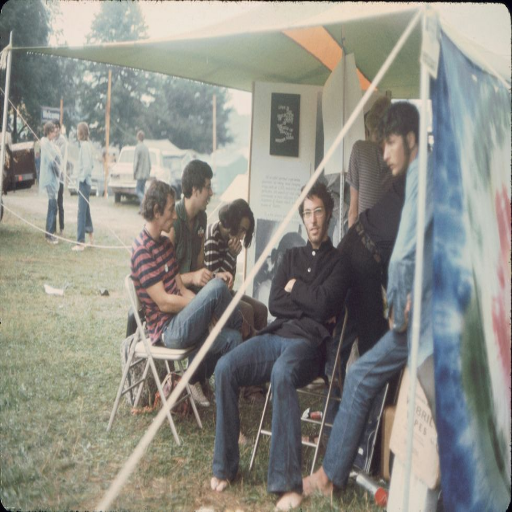

Epoch:1/10



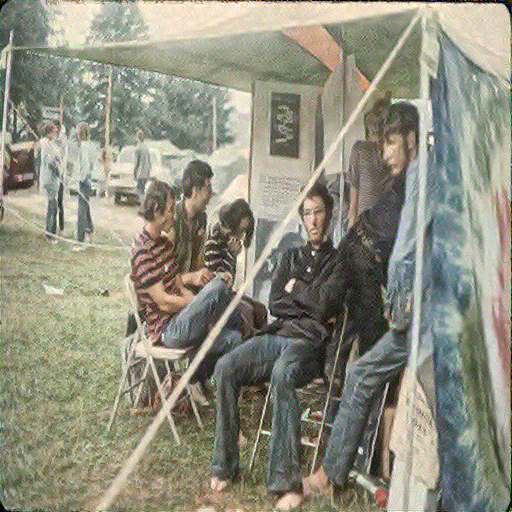

KeyboardInterrupt: 

In [38]:
epoch = 10
steps = 100

for n in range(epoch):
    print('Epoch:{}/10\n'.format(n))
    display.display(PIL.Image.fromarray(np.array(X[0]*255, dtype = np.uint8)))
    for m in range(steps):
        # print('Step:{}/100'.format(m))
        grad = gradients(model,X,style_gram=style_gram,content_outputs=content_outputs,weights=weights, alpha= 1e-1, beta = 1)
        optimizer.apply_gradients(grads_and_vars=[(grad,X)])
        X.assign(tf.clip_by_value(X, clip_value_min=0.0, clip_value_max=1.0),read_value=False)